# PencilGrids example

This example uses `PencilGrids` to demonstrate potential
use of `MPI`-based parallelism.

Note, however, that the online documentation is rendered by a single process and so using
`PencilGrids` has little practical benefit other than demonstrating how it is done.
If you run this example with multiple MPI processes, many of the `@info` statements will
print once for each process.


## Initialise a simulation

In [1]:
using MPI
using NPZ
using CairoMakie
using UltraDark

Initialise `MPI` and set up `MPI.Comm` for inter-process communication.

In [2]:
if ~MPI.Initialized()
    MPI.Init()
end
comm = MPI.COMM_WORLD
@info "Process ID $(MPI.Comm_rank(comm)+1) of $(MPI.Comm_size(comm)) with $(Threads.nthreads()) threads\n"

[ Info: Process ID 1 of 1 with 1 threads


Define grids on which simulation will be performed.
We use a relatively low resolution since this is just an example.

In [3]:
const resol = 64
const box_length = 10.0

grids = PencilGrids(box_length, resol)
@info "Grids created" MPI.Comm_rank(comm) size(grids.ψk)

┌ Info: Grids created
│   MPI.Comm_rank(comm) = 0
└   size(grids.ψk) = (64, 64, 64)


Define initial conditions consisting of a soliton of mass `mass` at position `position0`
with velocity `velocity`.

In [4]:
const mass = 10
const position0 = [-4, 0, 0]
const velocity = [1, 0, 0]
const phase = 0
const t0 = 0

UltraDark.Initialise.add_fdm_soliton!(grids, mass, position0, velocity, phase, t0)
UltraDark.update_gravitational_potential!(grids) # ensure the density is up to date
@info "Initialized" MPI.Comm_rank(comm) UltraDark.mass(grids)

┌ Info: Initialized
│   MPI.Comm_rank(comm) = 0
└   UltraDark.mass(grids) = 9.994786475858904


Define output configuration

In [5]:
const output_dir = joinpath(mktempdir(), "output")

const num_snapshots = 20
const output_times = LinRange(0, 5, num_snapshots)

output_config = OutputConfig(output_dir, output_times; box = true, slice = false);

## Run the simulation

In [6]:
simulate!(grids, output_config) == nothing
@info "Simulation complete" MPI.Comm_rank(comm)

[ Info: Reached time 0.2631578947368421
[ Info: Reached time 0.5263157894736841
[ Info: Reached time 0.7894736842105263
[ Info: Reached time 1.0526315789473684
[ Info: Reached time 1.31578947368421
[ Info: Reached time 1.5789473684210527
[ Info: Reached time 1.8421052631578942
[ Info: Reached time 2.1052631578947363
[ Info: Reached time 2.3684210526315783
[ Info: Reached time 2.6315789473684204
[ Info: Reached time 2.894736842105264
[ Info: Reached time 3.1578947368421053
[ Info: Reached time 3.4210526315789473
[ Info: Reached time 3.6842105263157894
[ Info: Reached time 3.9473684210526314
[ Info: Reached time 4.210526315789472
[ Info: Reached time 4.473684210526317
[ Info: Reached time 4.7368421052631575
[ Info: Reached time 4.999999999999998
┌ Info: Simulation complete
└   MPI.Comm_rank(comm) = 0


## Plot the results

Plotting and other analysis should only be done once, not repeated in every MPI job.
Here we do it on the root process by checking against the output of
`MPI.Comm_rank`.

First, plot the theoretical and numerical positions of the soliton's peak against time.
The error bars represent uncertainty due to the grid's finite resolution.

┌ Info: Plotting
└   MPI.Comm_rank(comm) = 0


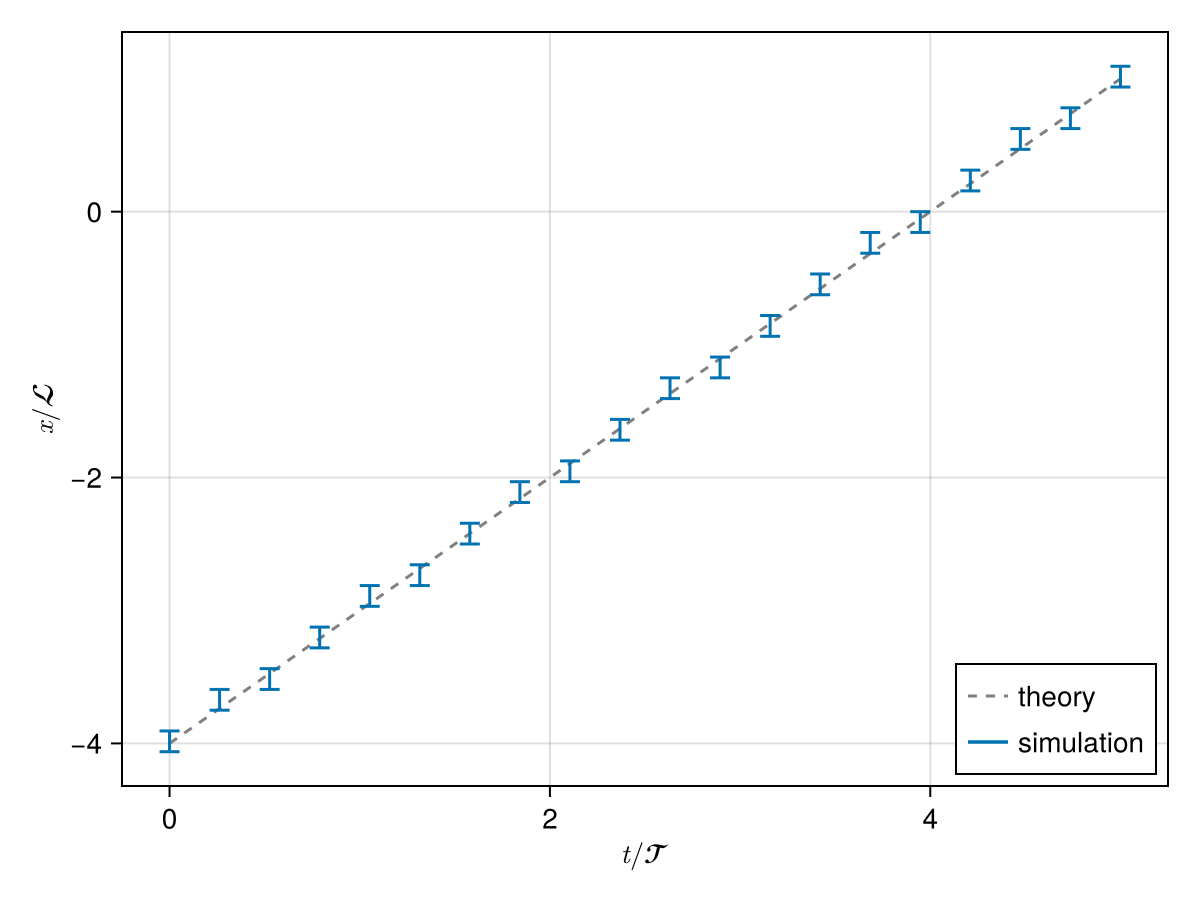

In [7]:
function plot_position()
    x = npzread(joinpath(output_dir, "x.npy"))
    y = npzread(joinpath(output_dir, "y.npy"))
    z = npzread(joinpath(output_dir, "z.npy"))

    position_sim = Array{Float64}(undef, (num_snapshots, 3))
    position_theory =
        reshape(position0, (1, :)) .+
        (reshape(velocity, (1, :)) .* reshape(output_times, (:, 1)))

    for i in 1:num_snapshots
        rho = npzread(joinpath(output_dir, "rho_$i.npy"))
        rhomax, maxindex = findmax(rho)
        position_sim[i, :] .= [x[maxindex[1]], y[maxindex[2]], z[maxindex[3]]]
    end

    yerr = abs(x[2] - x[1]) / 2

    fig = Figure()
    ax = Axis(fig[1, 1], xlabel = L"$t / \mathcal{T}$", ylabel = L"$x / \mathcal{L}$")
    lines!(
        ax,
        output_times,
        position_theory[:, 1],
        color = :gray,
        linestyle = :dash,
        label = "theory",
    )
    errorbars!(
        ax,
        output_times,
        position_sim[:, 1],
        yerr,
        whiskerwidth = 10,
        label = "simulation",
    )
    axislegend(ax, position = :rb)

    fig
end

if MPI.Comm_rank(comm) == 0
    @info "Plotting" MPI.Comm_rank(comm)
    plot_position()
end

Next, plot the maximum density as a function of time.
This would be approximately constant if the resolution was sufficiently high.

┌ Info: Plotting
└   MPI.Comm_rank(comm) = 0


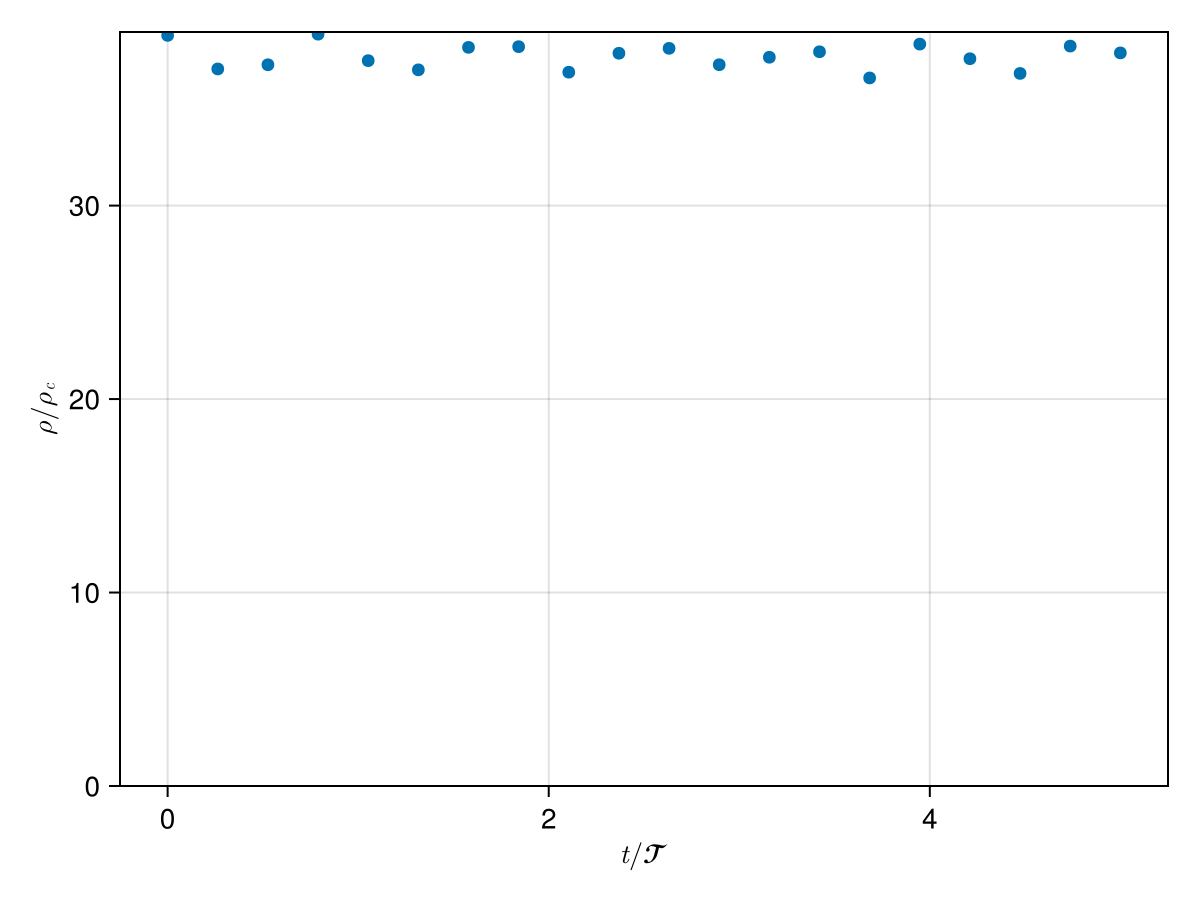

In [8]:
function plot_maximum()
    max_sim = Array{Float64}(undef, num_snapshots)

    for i in 1:num_snapshots
        rho = npzread(joinpath(output_dir, "rho_$i.npy"))
        rhomax, maxindex = findmax(rho)
        max_sim[i] = rhomax
    end

    fig = Figure()
    ax = Axis(
        fig[1, 1],
        xlabel = L"$t / \mathcal{T}$",
        ylabel = L"$\rho / \rho_c$",
        limits = (nothing, (0, nothing)),
    )
    scatter!(ax, output_times, max_sim, label = "simulation")

    fig
end

if MPI.Comm_rank(comm) == 0
    @info "Plotting" MPI.Comm_rank(comm)
    plot_maximum()
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*